Modelo entrenado


In [1]:
import os
import numpy as np
import cv2
from PIL import Image

from matplotlib import pyplot as plt
import matplotlib as matplotlib

from time import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import joblib
from collections import Counter
import numpy as np

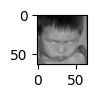

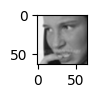

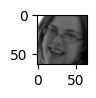

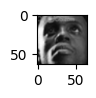

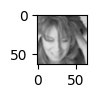

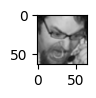

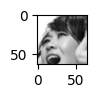

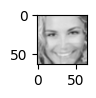

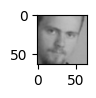

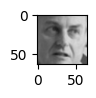

Train samples: 25102
Test samples: 6236
Number of classes: 5


In [2]:
import os
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import matplotlib

# Función para cargar imágenes desde carpeta
def load_dataset(folder_path, img_size=(48,48)):
    X = []
    Y = []
    class_labels = []
    nclasses = 0
    
    dpi = matplotlib.rcParams['figure.dpi']
    
    for class_name in sorted(os.listdir(folder_path)):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        class_labels.append(class_name)
        nsamples = 0
        
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith('.jpg'):
                img_path = os.path.join(class_folder, file_name)
                image = Image.open(img_path).convert("RGB")
                image = np.array(image)
                # Convierte a escala de grises
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Redimensiona
                gray = cv2.resize(gray, img_size)
                h, w = gray.shape
                X.append(gray.flatten())
                Y.append(nclasses)
                
                # Muestra la primera imagen de la clase
                if nsamples == 0:
                    figsize = w / float(dpi), h / float(dpi)
                    plt.figure(figsize=figsize)
                    plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
                    plt.show()
                nsamples += 1
        nclasses += 1
    
    return np.array(X, dtype='float32'), np.array(Y, dtype='int64'), class_labels, nclasses

# Rutas de train y test
train_folder = r"C:\Users\javie\Documents\TRABAJO UNI\VC\Vision_por_Computador\Práctica_5\train"
test_folder  = r"C:\Users\javie\Documents\TRABAJO UNI\VC\Vision_por_Computador\Práctica_5\test"

# Carga datasets
X_train, y_train, class_labels, n_classes = load_dataset(train_folder, img_size=(64,64))
X_test, y_test, _, _ = load_dataset(test_folder, img_size=(64,64))

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print("Number of classes:", len(class_labels))


PCA computation using 150 components from 25102 faces...
done in 6.843s
Projecting training and test on the eigenfaces orthonormal basis...
done in 0.553s


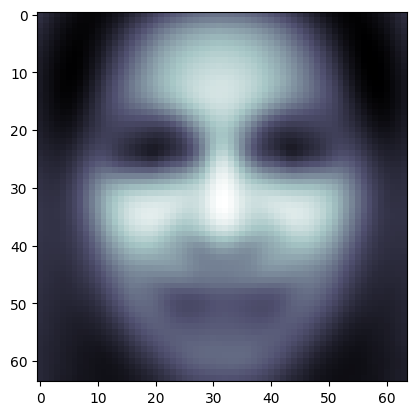

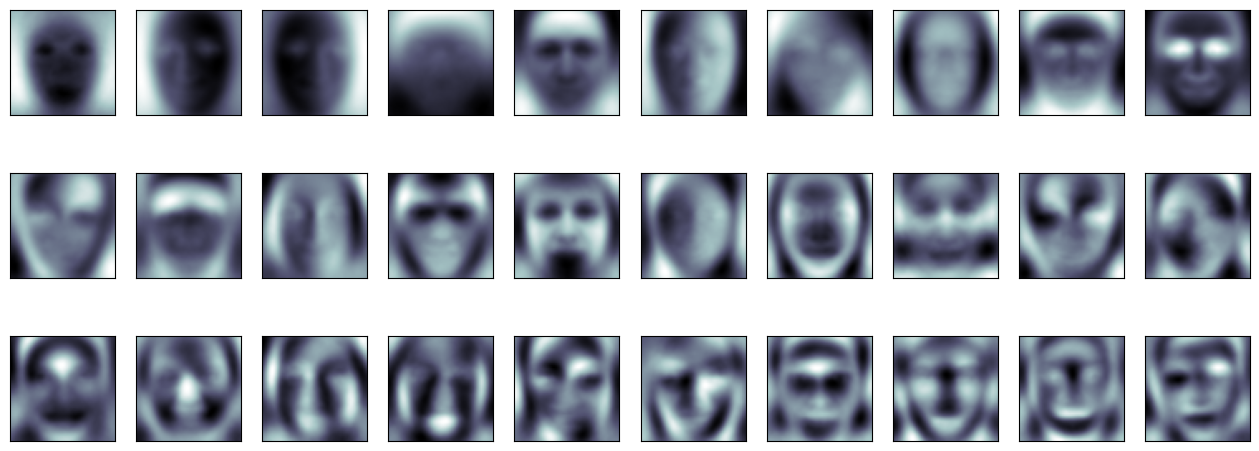

In [3]:
# Compute PCA on the training subset for n_comp components
n_comp = 150
print("PCA computation using %d components from %d faces..."
      % (n_comp, X_train.shape[0]))
t0 = time()
pca_n = PCA(n_components=n_comp, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces_n = pca_n.components_.reshape((n_comp, 64, 64))

print("Projecting training and test on the eigenfaces orthonormal basis...")
t0 = time()
X_train_pca_n = pca_n.transform(X_train)
X_test_pca_n = pca_n.transform(X_test)
print("done in %0.3fs" % (time() - t0))

# Cara media
plt.imshow(pca_n.mean_.reshape(64,64),            cmap=plt.cm.bone)

fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca_n.components_[i].reshape(64,64),
              cmap=plt.cm.bone)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import joblib
from collections import Counter
import numpy as np

pca_95 = PCA(n_components=150, svd_solver='randomized', whiten=False)
pca_95.fit(X_train)

X_train_pca_95 = pca_95.transform(X_train)
X_test_pca_95  = pca_95.transform(X_test)

scaler = MinMaxScaler()
train_X = scaler.fit_transform(X_train_pca_95)
test_X  = scaler.transform(X_test_pca_95)

counts = Counter(y_train)
n_classes = len(counts)
total = sum(counts.values())

class_weights = {k: total / (n_classes * v) for k, v in counts.items()}


parameters = {
    'C': [1, 10, 100, 1000],
    'gamma': [5e-3, 1e-2, 0.05, 0.1]
}


clf_pca_95 = GridSearchCV(
estimator=SVC(kernel='rbf', class_weight="balanced"),
param_grid=parameters,
cv=5,
n_jobs=-1,
verbose=3
)

clf_pca_95.fit(train_X, y_train)

joblib.dump({
"pca": pca_95,
"scaler": scaler,
"svm": clf_pca_95,
"labels": class_labels
}, "modelo_completo_4_pesos.pkl")


Fitting 5 folds for each of 16 candidates, totalling 80 fits


['modelo_completo_4_pesos.pkl']

In [ ]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Cargar el modelo completo
data = joblib.load("modelo_completo_4_pesos.pkl")
pca = data["pca"]
scaler = data["scaler"]
svm = data["svm"]
labels = data["labels"]

# 2. Transformar el test usando el mismo PCA y scaler
X_test_pca = pca.transform(X_test)
X_test_scaled = scaler.transform(X_test_pca)

# 3. Hacer predicciones
y_pred = svm.predict(X_test_scaled)

# 4. Evaluar exactitud
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 5. Informe detallado (precision, recall, f1)
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=labels))

# 6. Matriz de confusión
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.47177677998717127

Classification report:
              precision    recall  f1-score   support

       angry       0.34      0.32      0.33       958
        fear       0.44      0.39      0.41      1024
       happy       0.63      0.64      0.64      1774
     neutral       0.45      0.50      0.47      1233
         sad       0.38      0.38      0.38      1247

    accuracy                           0.47      6236
   macro avg       0.45      0.45      0.45      6236
weighted avg       0.47      0.47      0.47      6236


Confusion matrix:
[[ 305  123  188  150  192]
 [ 141  403  130  171  179]
 [ 143  114 1139  190  188]
 [ 124  115  169  618  207]
 [ 177  164  173  256  477]]


In [32]:
import cv2
import mediapipe as mp
import numpy as np
import joblib

# Cargar modelo
model = joblib.load("modelo_completo_4_pesos.pkl")
pca = model["pca"]
scaler = model["scaler"]
svm = model["svm"]
labels = model["labels"]

# Cargar filtros
emotion_filters = {}
for name, path in [("happy","filtros/feliz.png"),
                   ("sad","filtros/triste.png"),
                   ("angry","filtros/enfado.png"),
                   ("fear","filtros/miedo.png"),
                   ("neutral","filtros/neutral.png")]:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is not None and img.shape[2] == 4:
        emotion_filters[name] = {"color": img[:, :, :3], "alpha": img[:, :, 3]}
        print(f"Filtro {name} cargado correctamente.")
    else:
        print(f"Advertencia: filtro {name} no cargado correctamente")

# Overlay seguro y con mensajes
def overlay_image_alpha(img, img_overlay, pos, alpha_mask):
    try:
        x, y = int(pos[0]), int(pos[1])
        h, w = img_overlay.shape[:2]
        img_h, img_w = img.shape[:2]

        x1 = max(0, x - w // 2)
        y1 = max(0, y - h // 2)
        x2 = min(img_w, x1 + w)
        y2 = min(img_h, y1 + h)

        overlay_w = x2 - x1
        overlay_h = y2 - y1

        if overlay_w <= 0 or overlay_h <= 0:
            print("Overlay fuera de la imagen, no se aplica.")
            return img

        img_overlay_cropped = cv2.resize(img_overlay, (overlay_w, overlay_h))
        alpha_cropped = cv2.resize(alpha_mask, (overlay_w, overlay_h))
        alpha_factor = alpha_cropped[:, :, None] / 255.0

        img_crop = img[y1:y2, x1:x2]
        img[y1:y2, x1:x2] = (img_crop * (1 - alpha_factor) + img_overlay_cropped * alpha_factor).astype(np.uint8)
        print(f"Overlay aplicado en posición ({x}, {y}), tamaño ({overlay_w}, {overlay_h})")
        return img
    except Exception as e:
        print("Error en overlay:", e)
        return img

def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR)

def apply_filter_by_emotion(image, landmarks, filter_data, emotion, scale_factor=0.7):
    """
    Aplica el filtro en distintas posiciones según la emoción.
    """
    img_h, img_w = image.shape[:2]

    # Puntos clave de la cara
    p_left = landmarks.landmark[234]
    p_right = landmarks.landmark[454]
    p_top = landmarks.landmark[10]
    p_bottom = landmarks.landmark[152]
    p_left_eye = landmarks.landmark[33]
    p_right_eye = landmarks.landmark[263]

    x_left, y_left = int(p_left.x*img_w), int(p_left.y*img_h)
    x_right, y_right = int(p_right.x*img_w), int(p_right.y*img_h)
    x_top, y_top = int(p_top.x*img_w), int(p_top.y*img_h)
    x_bottom, y_bottom = int(p_bottom.x*img_w), int(p_bottom.y*img_h)
    x_left_eye, y_left_eye = int(p_left_eye.x*img_w), int(p_left_eye.y*img_h)
    x_right_eye, y_right_eye = int(p_right_eye.x*img_w), int(p_right_eye.y*img_h)

    # Ancho base del filtro
    width = int(np.linalg.norm([x_right - x_left, y_right - y_left]) * 2 * scale_factor)
    angle = -np.degrees(np.arctan2(y_right - y_left, x_right - x_left))

    filter_color = filter_data["color"]
    filter_alpha = filter_data["alpha"]

    new_h = int(filter_color.shape[0] * width / filter_color.shape[1])
    if new_h <= 0 or width <= 0:
        print("Tamaño del filtro no válido, no se aplica.")
        return image

    resized_color = cv2.resize(filter_color, (width, new_h))
    resized_alpha = cv2.resize(filter_alpha, (width, new_h))
    rotated_color = rotate_image(resized_color, angle)
    rotated_alpha = rotate_image(resized_alpha, angle)

    # Posición según emoción
    if emotion == "happy":
        pos = (x_left - width//4, y_top)  # izquierda de la cara
    elif emotion == "sad":
        pos = (x_left_eye, y_left_eye + new_h//2)  # debajo del ojo izquierdo
    else:  # angry, fear, neutral
        pos = (x_right + width//4, y_top - new_h//2)  # arriba a la derecha

    return overlay_image_alpha(image, rotated_color, pos, rotated_alpha)

# Inicializar cámara y FaceMesh
cap = cv2.VideoCapture(0)
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,
                           min_detection_confidence=0.5,
                           min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("No se pudo leer frame de la cámara")
            continue

        frame.flags.writeable = False
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)
        frame.flags.writeable = True

        if results.multi_face_landmarks:
            print("Cara detectada")
            for face_landmarks in results.multi_face_landmarks:
                img_h, img_w = frame.shape[:2]
                xs = [lm.x*img_w for lm in face_landmarks.landmark]
                ys = [lm.y*img_h for lm in face_landmarks.landmark]
                x_min, x_max = int(min(xs)), int(max(xs))
                y_min, y_max = int(min(ys)), int(max(ys))
                x_min, y_min = np.clip(x_min, 0, img_w-1), np.clip(y_min, 0, img_h-1)
                x_max, y_max = np.clip(x_max, 0, img_w-1), np.clip(y_max, 0, img_h-1)
                face = frame[y_min:y_max, x_min:x_max]

                if face.size == 0:
                    print("ROI de la cara vacío, no se procesa")
                    continue

                face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                face_resized = cv2.resize(face_gray, (64,64)).flatten().reshape(1,-1)
                pred_emotion = labels[svm.predict(scaler.transform(pca.transform(face_resized)))[0]]
                print("Emoción predicha:", pred_emotion)

                cv2.putText(frame, pred_emotion, (x_min, y_min-50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

                if pred_emotion in emotion_filters:
                    frame = apply_filter_by_emotion(frame, face_landmarks, emotion_filters[pred_emotion], pred_emotion, scale_factor=0.2)
                else:
                    print(f"No hay filtro disponible para la emoción: {pred_emotion}")
        else:
            print("No se detectó ninguna cara en este frame")

        cv2.imshow("Filtros de Emociones", frame)
        if cv2.waitKey(5) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()


Filtro happy cargado correctamente.
Filtro sad cargado correctamente.
Filtro angry cargado correctamente.
Filtro fear cargado correctamente.
Filtro neutral cargado correctamente.
Cara detectada
Emoción predicha: neutral
Overlay aplicado en posición (418, 123), tamaño (62, 62)
Cara detectada
Emoción predicha: fear
Overlay aplicado en posición (418, 129), tamaño (62, 53)
Cara detectada
Emoción predicha: fear
Overlay aplicado en posición (418, 129), tamaño (62, 53)
Cara detectada
Emoción predicha: neutral
Overlay aplicado en posición (417, 125), tamaño (62, 62)
Cara detectada
Emoción predicha: fear
Overlay aplicado en posición (418, 130), tamaño (62, 53)
Cara detectada
Emoción predicha: fear
Overlay aplicado en posición (418, 130), tamaño (62, 53)
Cara detectada
Emoción predicha: fear
Overlay aplicado en posición (418, 131), tamaño (62, 53)
Cara detectada
Emoción predicha: fear
Overlay aplicado en posición (418, 131), tamaño (62, 53)
Cara detectada
Emoción predicha: fear
Overlay aplicado 

In [ ]:
import cv2

# Load OpenCV face aye detectors
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Webcam connection
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Draw facial bounding boxes
    for (x, y, w, h) in faces:

        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Define region of interest (ROI) for eye detection
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = frame[y:y + h, x:x + w]

        # Detect eyes
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # Draw eye bounding boxes
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

    # Show resulting image
    cv2.imshow("Face and Eye Detection", frame)

     # Esc to finish
    tec = cv2.waitKey(40)
    if tec & tec == 27:  # Esc
        break

# Close windoews and release camera
cap.release()
cv2.destroyAllWindows()

Modelo Libre elección

In [11]:
import cv2
import mediapipe as mp
import time
import numpy as np
import os

def overlay_image_alpha(img, img_overlay, pos, alpha_mask):
    
    try:
        x, y = int(pos[0]), int(pos[1])
        h, w = img_overlay.shape[:2]
        img_h, img_w = img.shape[:2]


        y_min = y - h // 2
        y_max = y_min + h
        x_min = x - w // 2
        x_max = x_min + w


        y1_roi = max(0, y_min)
        y2_roi = min(img_h, y_max)
        x1_roi = max(0, x_min)
        x2_roi = min(img_w, x_max)
        
        img_cropped = img[y1_roi:y2_roi, x1_roi:x2_roi]
        

        y1_overlay = max(0, -y_min)
        y2_overlay = max(0, y_max - img_h)
        x1_overlay = max(0, -x_min)
        x2_overlay = max(0, x_max - img_w)

        img_overlay_cropped = img_overlay[y1_overlay : h - y2_overlay, x1_overlay : w - x2_overlay]
        alpha_cropped = alpha_mask[y1_overlay : h - y2_overlay, x1_overlay : w - x2_overlay]


        if img_cropped.shape[:2] != img_overlay_cropped.shape[:2]:
            img_overlay_cropped = cv2.resize(img_overlay_cropped, (img_cropped.shape[1], img_cropped.shape[0]))
            alpha_cropped = cv2.resize(alpha_cropped, (img_cropped.shape[1], img_cropped.shape[0]))


        alpha_factor = alpha_cropped[:, :, None] / 255.0
        
        img[y1_roi:y2_roi, x1_roi:x2_roi] = (
            img_cropped * (1 - alpha_factor) + 
            img_overlay_cropped * alpha_factor
        ).astype(np.uint8)
        
        return img
    
    except Exception as e:
        return img 

def rotate_image(image, angle, center=None, scale=1.0):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR)
    return rotated


try:
    hat_img_orig = cv2.imread('gorro.png', cv2.IMREAD_UNCHANGED)
    if hat_img_orig is None:
        raise FileNotFoundError("No se pudo cargar el gorro")
    
    hat_color = hat_img_orig[:, :, :3]  
    hat_alpha = hat_img_orig[:, :, 3]
    print("Gorro cargado.")
except FileNotFoundError as e:
    print(e)
    hat_img_orig = None

cap = cv2.VideoCapture(1)
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:

    mouth_open_threshold = 0.04 
    is_mouth_open = False

    start_time = time.time()
    

    animation_frames = []
    animation_current_frame_idx = 0
    animation_last_update_time = 0
    animation_speed = 0.04 
    try:
        folder_path = "animacion_cartas"
        if os.path.exists(folder_path):
            for filename in sorted(os.listdir(folder_path)):
                if filename.endswith(".png"):
                    img_path = os.path.join(folder_path, filename)
                    frame = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                    if frame is not None:
                        animation_frames.append(frame)
            print(f"Cargados {len(animation_frames)}.")
    except FileNotFoundError as e:
        print(e)

    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        image.flags.writeable = False
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)
        image.flags.writeable = True
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:

                # Gorro

                if hat_img_orig is not None:

                    img_h, img_w, _ = image.shape
                    
                    p_top = face_landmarks.landmark[10] 
                    p_left_side = face_landmarks.landmark[234] 
                    p_right_side = face_landmarks.landmark[454] 

                    x_top, y_top = int(p_top.x * img_w), int(p_top.y * img_h)
                    x_left, y_left = int(p_left_side.x * img_w), int(p_left_side.y * img_h)
                    x_right, y_right = int(p_right_side.x * img_w), int(p_right_side.y * img_h)

                    hat_desired_width = np.linalg.norm(np.array([x_left, y_left]) - np.array([x_right, y_right]))
                    hat_desired_width *= 2.

                    angle_radians = np.arctan2(y_right - y_left, x_right - x_left)
                    angle_degrees = np.degrees(angle_radians)
                    angle_degrees = -angle_degrees

                    hat_scale_factor = hat_desired_width / hat_img_orig.shape[1]
                    new_hat_width = int(hat_img_orig.shape[1] * hat_scale_factor)
                    new_hat_height = int(hat_img_orig.shape[0] * hat_scale_factor)
                    
                    if new_hat_width > 0 and new_hat_height > 0:
                        resized_hat_color = cv2.resize(hat_color, (new_hat_width, new_hat_height), interpolation=cv2.INTER_AREA)
                        resized_hat_alpha = cv2.resize(hat_alpha, (new_hat_width, new_hat_height), interpolation=cv2.INTER_AREA)

                        rotated_hat_color = rotate_image(resized_hat_color, angle_degrees)
                        rotated_hat_alpha = rotate_image(resized_hat_alpha, angle_degrees)

                        hat_pos_x = x_top
                        hat_pos_y = y_top - int(new_hat_height * 0.4)

                        image = overlay_image_alpha(image, rotated_hat_color, (hat_pos_x, hat_pos_y), rotated_hat_alpha)


                # Labios
                p_lip_top = face_landmarks.landmark[13]
                p_lip_bottom = face_landmarks.landmark[14]


                p_forehead = face_landmarks.landmark[10]
                p_chin = face_landmarks.landmark[152]
                
                face_height = np.linalg.norm(np.array([p_forehead.x, p_forehead.y]) - np.array([p_chin.x, p_chin.y]))
                
                if face_height > 0: 
                    mouth_distance_norm = abs(p_lip_top.y - p_lip_bottom.y) / face_height
                else:
                    mouth_distance_norm = 0
                
                if mouth_distance_norm > mouth_open_threshold:
                    if not is_mouth_open:
                        is_mouth_open = True
                        animation_current_frame_idx = 0
                        animation_last_update_time = time.time()

                    if time.time() - animation_last_update_time > animation_speed:
                        if len(animation_frames) > 0:
                            animation_current_frame_idx = (animation_current_frame_idx + 1) % len(animation_frames)
                        animation_last_update_time = time.time()

                    if len(animation_frames) > 0:
                        current_frame = animation_frames[animation_current_frame_idx]
                        anim_h, anim_w = current_frame.shape[:2]

                        p_mouth_top = face_landmarks.landmark[13]
                        p_mouth_bottom = face_landmarks.landmark[14]
                        
                        cx_mouth = int((p_mouth_top.x + p_mouth_bottom.x) / 2 * img_w)
                        cy_mouth = int((p_mouth_top.y + p_mouth_bottom.y) / 2 * img_h)

                        p_left = face_landmarks.landmark[234]
                        p_right = face_landmarks.landmark[454]
                        face_width_px = np.linalg.norm(
                            np.array([p_left.x * img_w, p_left.y * img_h]) - 
                            np.array([p_right.x * img_w, p_right.y * img_h])
                        )

                        desired_anim_width = int(face_width_px * 0.8) 
                        scale_factor = desired_anim_width / anim_w
                        
                        new_anim_w = int(anim_w * scale_factor)
                        new_anim_h = int(anim_h * scale_factor)


                        if new_anim_w > 0 and new_anim_h > 0:
                            resized_anim = cv2.resize(current_frame, (new_anim_w, new_anim_h), interpolation=cv2.INTER_AREA)
                            
                            anim_color = resized_anim[:, :, :3]
                            anim_alpha = resized_anim[:, :, 3]


                            dy = (p_right.y * img_h) - (p_left.y * img_h)
                            dx = (p_right.x * img_w) - (p_left.x * img_w)
                            angle_degrees = np.degrees(np.arctan2(dy, dx))

                            rotated_anim_color = rotate_image(anim_color, angle_degrees)
                            rotated_anim_alpha = rotate_image(anim_alpha, angle_degrees)


                            offset_y = int(new_anim_h / 2)
                            
                            image = overlay_image_alpha(
                                image, 
                                rotated_anim_color, 
                                (cx_mouth, cy_mouth + offset_y),
                                rotated_anim_alpha
                            )

                else:
                    if is_mouth_open:
                        is_mouth_open = False


        end_time = time.time()
        start_time = end_time
        cv2.imshow('Filtro del Mago', image)

        if cv2.waitKey(5) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()

Gorro cargado.
Cargados 21.
